In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import io
import os
import pathlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist
from bioinfokit.visuz import cluster
import dataframe_image as dfi

############################################
############### Parsing dati ###############

#Lettura dati da dataset
path = str(pathlib.Path().absolute())
path_high_lev = path + "/prova1_high_level.csv"
path_low_lev = path + "/prova1_low_level.txt"


df_high = pd.read_csv(path_high_lev)
df_low = pd.read_csv(path_low_lev, skiprows=[0,2,3], delimiter=r"\s+")

df_low = df_low.drop(df_low.tail(8).index)

In [2]:
dfi.export(df_high,"df_high.png", max_rows=10)
df_high

,timeStamp,elapsed,label,responseCode,responseMessage,threadName,dataType,success,failureMessage,bytes,sentBytes,grpThreads,allThreads,URL,Latency,IdleTime,Connect
0,1608199962067,7,HTTP Request small,200,OK,Thread Group 1 1-1,bin,True,NaN,152918,133,1,1,http://192.168.56.101/jupiter_small.jpg,4,0,2
1,1608199962116,185,HTTP Request small,200,OK,Thread Group 2 2-1,bin,True,NaN,152918,133,1,3,http://192.168.56.101/jupiter_small.jpg,116,0,115
2,1608199962211,93,HTTP Request small,200,OK,Thread Group 3 3-1,bin,True,NaN,152918,133,1,3,http://192.168.56.101/jupiter_small.jpg,29,0,20
3,1608199962567,26,HTTP Request mid,200,OK,Thread Group 1 1-1,bin,True,NaN,1031744,133,1,3,http://192.168.56.101/cassiopea_mid.jpg,2,0,0
4,1608199963070,6,HTTP Request small,200,OK,Thread Group 1 1-2,bin,True,NaN,152918,133,2,4,http://192.168.56.101/jupiter_small.jpg,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1608200261212,306,HTTP Request big,200,OK,Thread Group 3 3-2,bin,True,NaN,2962330,133,2,5,http://192.168.56.101/andromeda_big.jpg,6,0,3
1223,1608200261258,271,HTTP Request big,200,OK,Thread Group 3 3-8,bin,True,NaN,2962330,133,1,4,http://192.168.56.101/andromeda_big.jpg,6,0,2
1224,1608200261567,12,HTTP Request small,200,OK,Thread Group 1 1-1,bin,True,NaN,152918,133,3,3,http://192.168.56.101/jupiter_small.jpg,5,0,3
1225,1608200261568,27,HTTP Request small,200,OK,Thread Group 1 1-3,bin,True,NaN,152918,133,2,2,http://192.168.56.101/jupiter_small.jpg,8,0,4


In [3]:
df_rid_high = pd.DataFrame(df_high[['timeStamp', 'elapsed', 'label', 'threadName', 'bytes', 'Latency']])

df_rid_high["size_group"] = df_rid_high.apply(lambda x: x['label'].split(" ")[2]+'-'+ x['threadName'].split(" ")[2], axis=1)

df_rid_high['size_group'].unique()

array(['small-1', 'small-2', 'small-3', 'mid-1', 'big-1', 'mid-2',
       'big-2', 'mid-3', 'big-3'], dtype=object)

In [4]:
encoder = LabelEncoder()
encoder.fit(df_rid_high['size_group'].unique()) #decidere ordine
# print(encoder.classes_)
df_rid_high.size_group = encoder.transform(df_rid_high.size_group)

df_rid_high['size_group'].unique()

coded = list(encoder.inverse_transform([0,1,2,3,4,5,6,7,8]))

for i,x in enumerate(coded):
    print(i,x)
    
df_rid_high.drop(columns=['label', 'threadName'], inplace=True)

0 big-1
1 big-2
2 big-3
3 mid-1
4 mid-2
5 mid-3
6 small-1
7 small-2
8 small-3


In [5]:
dfi.export(df_rid_high,"df_rid_high.png", max_rows=10)

# PCA HIGH LEVEL

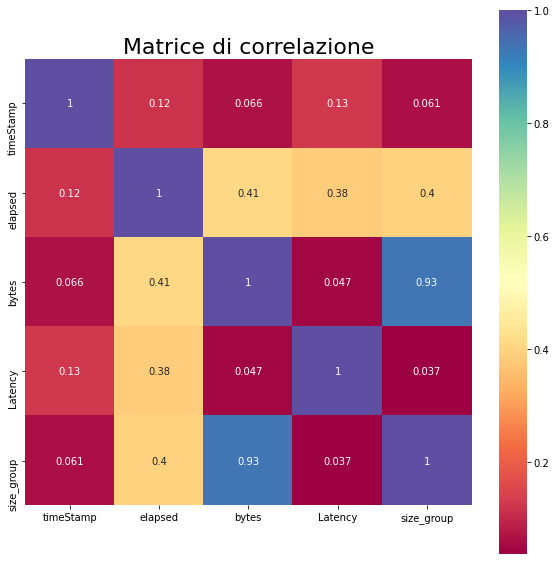

In [6]:
corrMatrix = df_rid_high.corr()
plt.figure(figsize = (10, 10))
plt.title('Matrice di correlazione', size=22)
sn.heatmap(abs(corrMatrix), annot=True, cmap='Spectral', square=True)
plt.show();

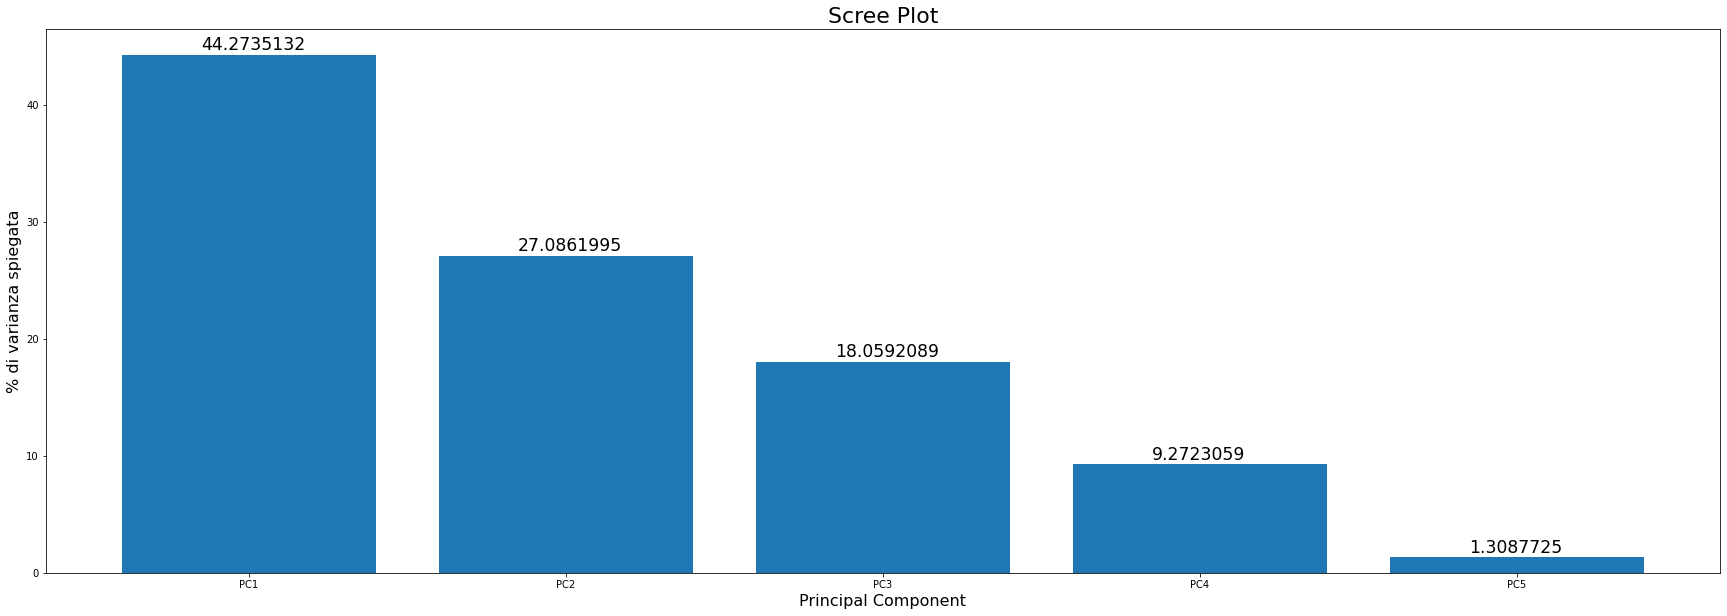

In [7]:
# Normalizzazione Z-score
x = StandardScaler().fit_transform(df_rid_high)
scaled_df = pd.DataFrame(x)


##############################################
################# PCA ########################

pca = PCA() #modello
pca.fit(scaled_df) #aggiunta dataset
pca_data = pca.transform(scaled_df) #creazione 

#Calcolo percentuali di varianza spiegata per ogni PCi
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=7)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

# Definizione PCA dataframe
pca_df = pd.DataFrame(pca_data, columns=labels)

plt.figure(figsize = (30, 10))
plt.ylabel('% di varianza spiegata', size=16)
plt.xlabel('Principal Component', size=16)
plt.title('Scree Plot', size=22)
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels, align='center')
# Annotazione percentuali
i = 0; j = 0.4
for i in range(len(per_var)):
    plt.annotate('{:.7f}'.format(per_var[i]), (i+0.85, per_var[i] + j), fontsize="xx-large")
plt.show()

#Autovalori
eigenvalues = pca.explained_variance_

In [8]:
pca_variance = per_var[0]+per_var[1]+per_var[2]
pca_variance

89.41892159999999

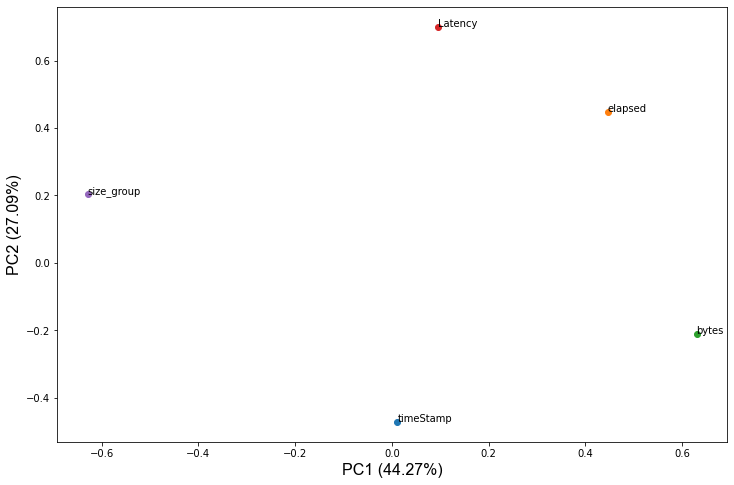

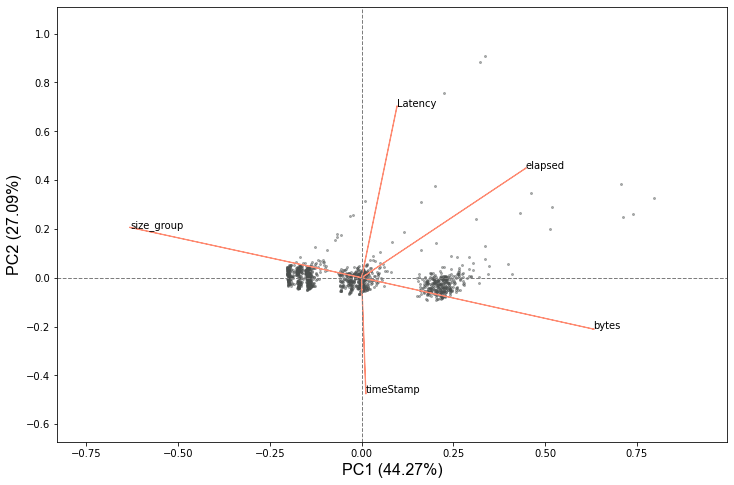

In [9]:
loadings = pca.components_
num_pc = pca.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = df_rid_high.columns.values
loadings_df = loadings_df.set_index('variable')

cluster.pcaplot(x=loadings[0], y=loadings[1], labels=df_rid_high.columns.values, var1=round(pca.explained_variance_ratio_[0]*100, 2), var2=round(pca.explained_variance_ratio_[1]*100, 2), axlabelfontsize=16, dim = (12,8), show=True) # plotlabels= False
cluster.biplot(cscore=pca_data, loadings=loadings, labels=df_rid_high.columns.values, var1=round(pca.explained_variance_ratio_[0]*100, 2), var2=round(pca.explained_variance_ratio_[1]*100, 2), axlabelfontsize=16, dim = (12,8), valphadot = 0.4, dotsize = 4, show=True)

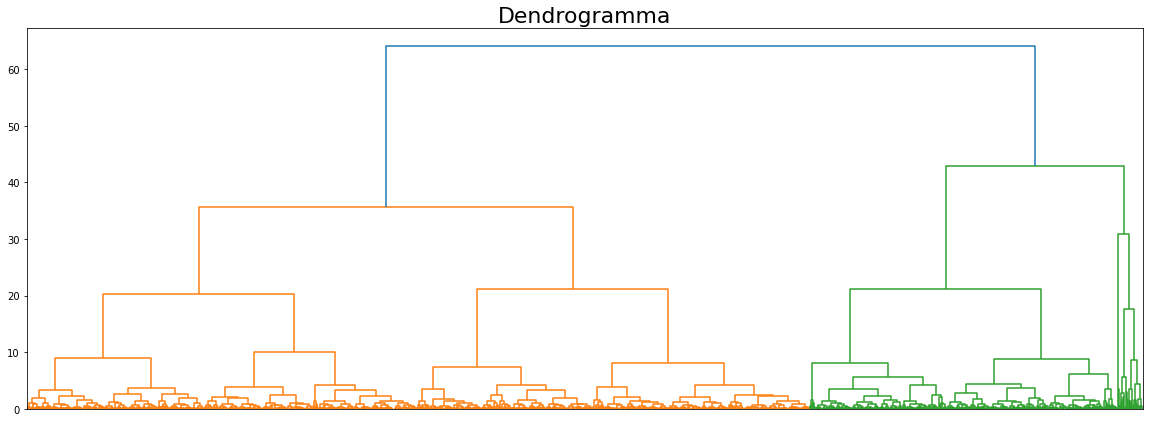

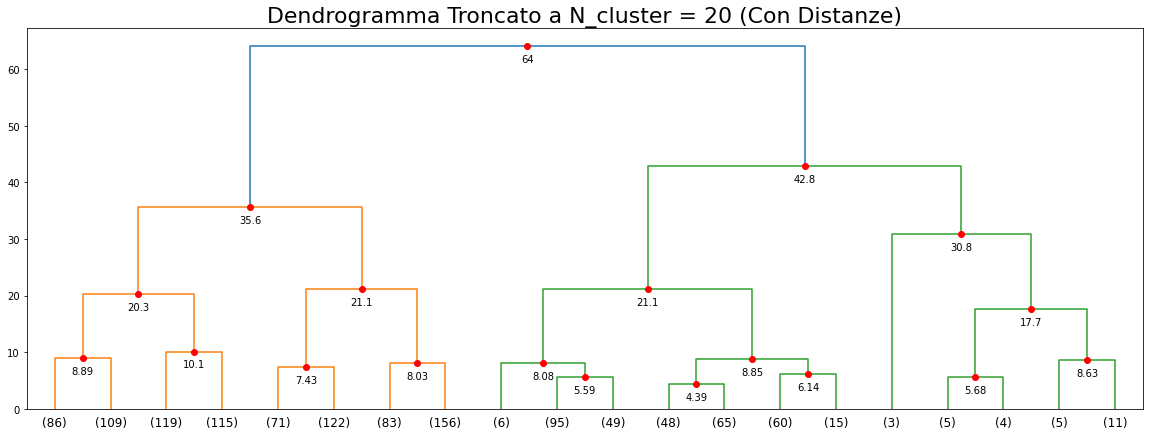

In [10]:
pca89_df = pca_df[pca_df.columns[0:3]]


#Calcolo devianza spiegata dalla PCA 
dev_pca = ((pca89_df - pca89_df.mean(axis=0))**2).values.sum()
#Calcolo devianza totale del modello
dev_tot = ((scaled_df - scaled_df.mean(axis=0))**2).values.sum()
#dev_pca_perc2 = dev_pca/dev_tot #più precisa
#Calcolo devianza percentuale spiegata dalla PCA
dev_pca_percentuale = per_var[0:3].sum()/100

linkage_matrix = sch.linkage(pca89_df, method  = "ward")

plt.figure(figsize = (20, 7))
dendrogram = sch.dendrogram(linkage_matrix, no_labels='true')
plt.title('Dendrogramma', size=22)
plt.xlabel('')
plt.ylabel('')
plt.show()

def augmented_dendrogram(*args, **kwargs):

    ddata = sch.dendrogram(*args, **kwargs)
    distanze = []
    if not kwargs.get('no_plot', False):
        for i, d in zip(ddata['icoord'], ddata['dcoord']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            distanze.append(y)
            plt.plot(x, y, 'ro')
            plt.annotate("%.3g" % y, (x, y), xytext=(0, -8),
                         textcoords='offset points',
                         va='top', ha='center')
    distanze.sort(reverse=True)
    return ddata, distanze

p = 20

plt.figure(figsize = (20, 7))
_, distanze = augmented_dendrogram(linkage_matrix, p, truncate_mode='lastp')
plt.title('Dendrogramma Troncato a N_cluster = 20 (Con Distanze)', size=22)
plt.xlabel('')
plt.ylabel('')
plt.show();

distance_table= pd.DataFrame()
distance_table['Numero cluster'] = range(1,p)
distance_table['Distanza'] = distanze

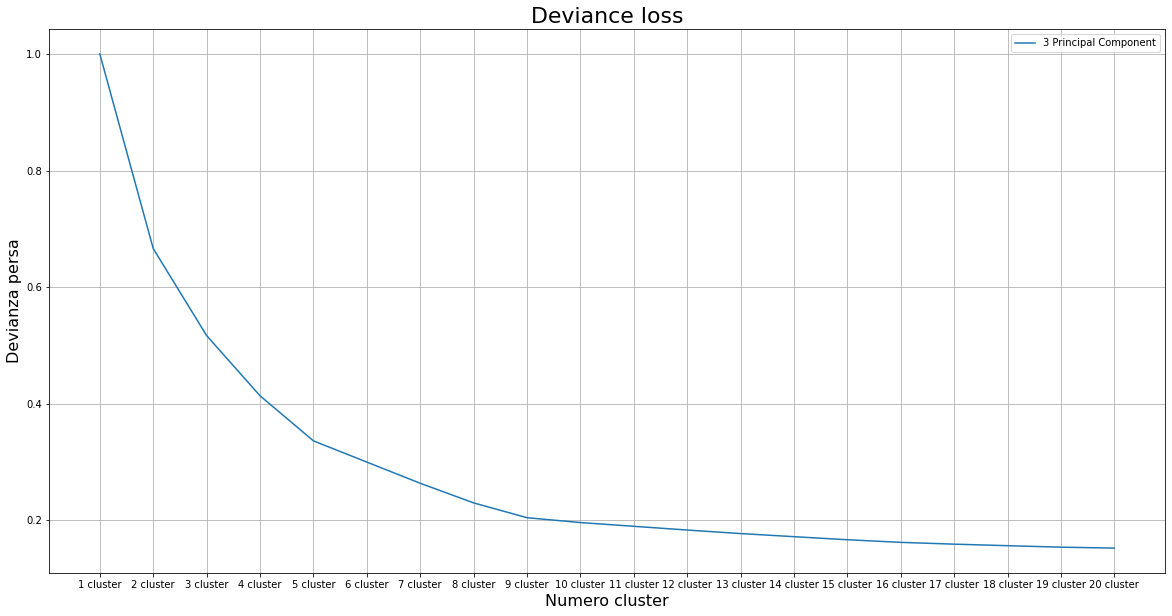

In [11]:
pca_df_dict={}

scelta_cluster_dict={}

cluster_df_dict={}

#Calcolo devianza totale del modello
dev_tot = ((scaled_df - scaled_df.mean(axis=0))**2).values.sum()

#Calcolo dimensione totale DATASET di partenza
dim_tot = scaled_df.size

k = 3

numero_cluster = 20;


pca_df_dict[k] = pd.DataFrame(pca_df[pca_df.columns[0:k]])


#Calcolo devianza spiegata dalla PCA 
dev_pca = ((pca_df_dict[k] - pca_df_dict[k].mean(axis=0))**2).values.sum()
#dev_pca_perc2 = dev_pca/dev_tot #più precisa
#Calcolo devianza percentuale spiegata dalla PCA
dev_pca_percentuale = per_var[0:k+1].sum()/100

linkage_matrix = sch.linkage(pca_df_dict[k], method  = "ward")

#     plt.figure(figsize = (20, 7))
#     dendrogram = sch.dendrogram(linkage_matrix, no_labels='true')
#     plt.title('Dendrogramma', size=22)
#     plt.xlabel('')
#     plt.ylabel('')
#     plt.show()

#     plt.figure(figsize = (20, 7))
#     _, distanze = augmented_dendrogram(linkage_matrix, numero_cluster, truncate_mode='lastp')
#     plt.title('Dendrogramma Troncato a N_cluster = 20 (Con Distanze)', size=22)
#     plt.xlabel('')
#     plt.ylabel('')
#     plt.show();

#     distance_table= pd.DataFrame()
#     distance_table['Numero cluster'] = range(1,p)
#     distance_table['Distanza'] = distanze


cluster_df = pd.DataFrame()

scelta_cluster_dict[k] = pd.DataFrame(columns=["N cluster", "dev_loss", "dev_rimasta", "dim_ratio"])

for p in range(1,numero_cluster+1):
    array_dist = fcluster(linkage_matrix, p, criterion='maxclust')
    col_label = str(p)+" cluster"
    cluster_df[col_label]=array_dist



cluster_df_dict[k] = cluster_df

for cont,i in enumerate(cluster_df.columns, 1):
    dev_intra = 0; dev_inter = 0

    gruppi = cluster_df[i].groupby(cluster_df[i])
    for gr in range(1,max(cluster_df[i])+1):
        gruppetto = pd.DataFrame(gruppi.get_group(gr))
        gruppetto = gruppetto.join(pca_df_dict[k])
        gruppetto = gruppetto.drop(columns=[i])
        centroid = gruppetto.mean(axis = 0)
        centroid = centroid.to_numpy()
        dev_intra = dev_intra + ((gruppetto-centroid)**2).values.sum()
        dev_inter = dev_inter + len(gruppetto)*(((centroid-pca_df_dict[k].mean(axis=0))**2).values.sum())


    dev_lost_percentuale = (1 - dev_pca/dev_tot)+(dev_intra/dev_tot)
    dev_pca_cl_per = dev_inter/dev_tot
    dim_ratio =  (cont * k) / dim_tot

#         print((dev_intra + dev_inter)/dev_pca)

    new_row = {'N cluster':i, 'dev_loss':dev_lost_percentuale, 'dev_rimasta':dev_pca_cl_per, 'dim_ratio':dim_ratio}
    scelta_cluster_dict[k] = scelta_cluster_dict[k].append(new_row, ignore_index=True)


plt.figure(figsize = (20, 10))

plt.plot(scelta_cluster_dict[k]["N cluster"], scelta_cluster_dict[k]["dev_loss"], label='{} Principal Component'.format(k))
plt.legend(loc='upper right')
plt.title('Deviance loss', size=22)
plt.xlabel('Numero cluster', size=16)
plt.ylabel('Devianza persa', size=16)
plt.grid()
plt.show()

# plt.figure(figsize = (20, 10))
# for k in range(min_pc,max_pc+1):
# #         plt.plot(scelta_cluster_dict[k]["N cluster"], scelta_cluster_dict[k]["dev_loss"]*((scelta_cluster_dict[k]["dim_ratio"]- min(scelta_cluster_dict[k]["dim_ratio"]))/(max(scelta_cluster_dict[k]["dim_ratio"]) - min(scelta_cluster_dict[k]["dim_ratio"]))), label='{} Principal component'.format(k))
#     plt.plot(scelta_cluster_dict[k]["N cluster"], scelta_cluster_dict[k]["dev_loss"]*(scelta_cluster_dict[k]["dim_ratio"]/max(scelta_cluster_dict[k]["dim_ratio"])), label='{} Principal component'.format(k))
# plt.legend(loc='lower right')
# plt.title('Dimensionality reduction & Deviance loss', size=22)
# plt.xlabel('Numero cluster', size=16)
# plt.ylabel('Devianza persa * dimension reduction ratio', size=16)
# plt.grid()
# plt.show()

# Direi che pigliamo 5 cluster

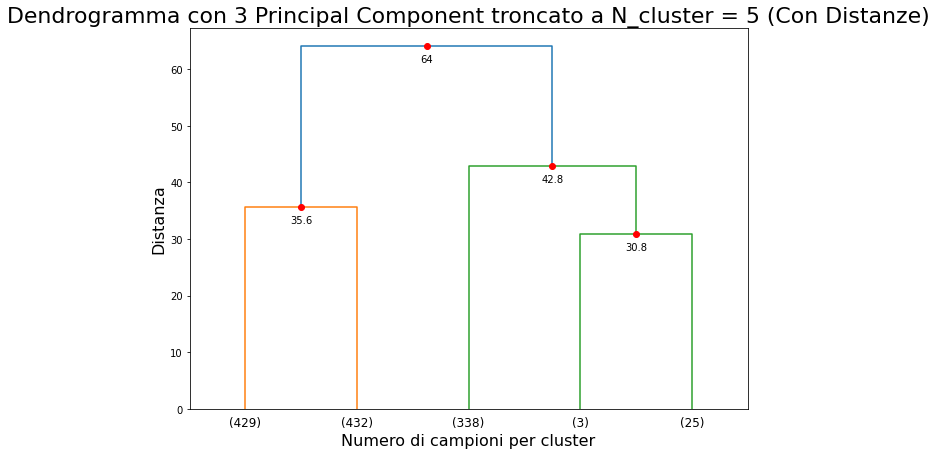

   Numero cluster   Distanza
0               1  63.996495
1               2  42.807581
2               3  35.585518
3               4  30.807213


In [12]:
linkage_matrix = sch.linkage(pca_df_dict[k], method  = "ward")
plt.figure(figsize = (10, 7))
_, distanze = augmented_dendrogram(linkage_matrix, 5, truncate_mode='lastp')
plt.title('Dendrogramma con 3 Principal Component troncato a N_cluster = 5 (Con Distanze)', size=22)
plt.xlabel('Numero di campioni per cluster', size = 16)
plt.ylabel('Distanza', size = 16)
plt.show();

distance_table= pd.DataFrame()
distance_table['Numero cluster'] = range(1,5)
distance_table['Distanza'] = distanze

print(distance_table)

In [13]:
scelta_cluster_dict[3]

,N cluster,dev_loss,dev_rimasta,dim_ratio
0,1 cluster,1.000000,0.000000,0.000489
1,2 cluster,0.666214,0.333786,0.000978
2,3 cluster,0.516867,0.483133,0.001467
3,4 cluster,0.413662,0.586338,0.001956
4,5 cluster,0.336312,0.663688,0.002445
5,6 cluster,0.299881,0.700119,0.002934
6,7 cluster,0.263584,0.736416,0.003423
7,8 cluster,0.229896,0.770104,0.003912
8,9 cluster,0.204475,0.795525,0.004401
9,10 cluster,0.196147,0.803853,0.004890


1
   size_group  occorrenze      ext
0           6         115  small-1
1           3         100    mid-1
2           8          61  small-3
3           7          58  small-2
4           4          53    mid-2
5           5          42    mid-3
2
   size_group  occorrenze      ext
0           3         101    mid-1
1           6          99  small-1
2           7          84  small-2
3           4          59    mid-2
4           8          56  small-3
5           5          33    mid-3
3
   size_group  occorrenze    ext
0           0         196  big-1
1           1          96  big-2
2           2          45  big-3
3           3           1  mid-1
4
   size_group  occorrenze      ext
0           6           2  small-1
1           7           1  small-2
5
   size_group  occorrenze      ext
0           6           7  small-1
1           3           5    mid-1
2           4           4    mid-2
3           0           3    big-1
4           7           2  small-2
5           1       

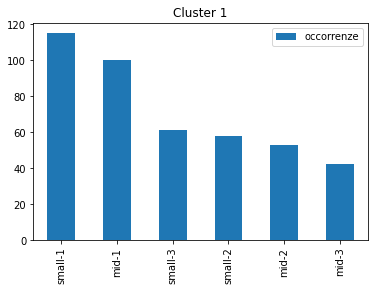

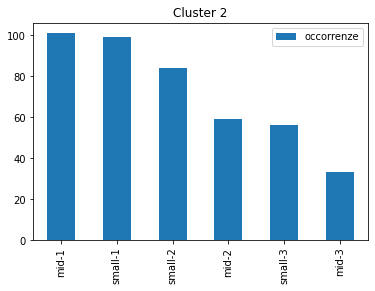

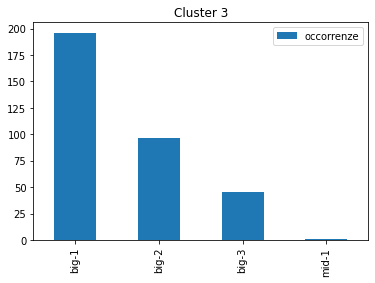

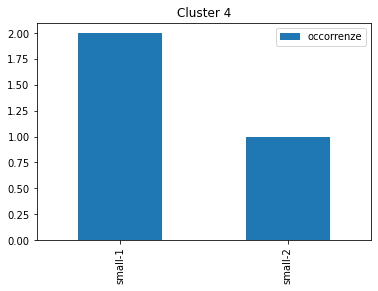

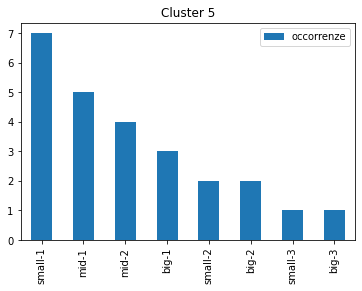

In [18]:
df_rid_high["5_cluster"] = cluster_df_dict[k]["5 cluster"]

grs = df_rid_high.groupby("5_cluster")

# print(df_rid_high.size_group.value_counts())

for g in grs:
    print(g[0])
    massimo=grs.get_group(g[0])['size_group'].value_counts()
    massimo = pd.DataFrame(massimo.reset_index().values, columns=["size_group", "occorrenze"])
    temp = list(encoder.inverse_transform(massimo.size_group))
    massimo['ext'] = temp
    massimo.plot(x="ext", y="occorrenze", kind="bar", xlabel="", title="Cluster {}".format(g[0]))
    print(massimo)

# Scelta samples per cluster:

- cluster 1: 6
- cluster 2: 3
- cluster 3: 0
- cluster 4: 7
- cluster 5: 6

In [15]:
grs = df_rid_high.groupby("5_cluster")

dict_cluster = {'1':6, '2':3, '3':0, '4':7, '5':6}

index_list = []

for g in grs:
    temp = pd.DataFrame(grs.get_group(g[0]))
    s = temp.loc[temp['size_group'] == dict_cluster[str(g[0])]].sample(random_state=42)
    index_list.append(s.index[0])


synt_workload = df_high[df_high.index.isin(index_list)]
synt_workload
dfi.export(synt_workload,"synt_workload.png", max_rows=10)

# CHE AMMA FA?

- Thread group 1 deve fa 2 rich small, 1 big e 1 mid